In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'


### 동대문구 내 따릉이 대여소 정보

In [2]:
Bike_Stop = pd.read_excel('./raw data/대여소/서울특별시 공공자전거 대여소 정보(19.12.9).xlsx')
Bike_Stop_ID = Bike_Stop.groupby('대여소_구')['대여소ID'].unique().loc['동대문구']
#Bike_Stop_ID = np.append(Bike_Stop_ID, 664)
Bike_Stop_ID = Bike_Stop_ID.astype(np.int64)
Bike_Stop_ID

array([600, 601, 602, 604, 605, 606, 607, 608, 609, 610, 612, 613, 614,
       615, 616, 617, 621, 622, 623, 624, 625, 626, 627, 628, 630, 631,
       633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 646, 647,
       648, 650, 651, 652, 654, 656, 657, 658, 659, 660, 661, 663],
      dtype=int64)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
import xgboost as xgb
from scipy.stats import uniform, randint
import pickle
import os

In [4]:
dayofweek = ["요일_"+str(i) for i in range(7)]
features = ['월', '시간', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 풍속(m/s)', '평균 상대습도(%)'] + dayofweek
features

['월',
 '시간',
 '최저기온(°C)',
 '최고기온(°C)',
 '일강수량(mm)',
 '최대 풍속(m/s)',
 '평균 상대습도(%)',
 '요일_0',
 '요일_1',
 '요일_2',
 '요일_3',
 '요일_4',
 '요일_5',
 '요일_6']

### xgboost 모델 불러오기 (pkl)

#### Inflow

In [5]:
dirs_in = os.getcwd() + '/model/Inflow'
files_in = os.listdir(dirs_in)
#files_in

In [6]:
cols = ['월', '요일', '시간', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 풍속(m/s)', '평균 상대습도(%)']
Model_Inflow = {}

In [7]:
in_pkl_path = "./model/Inflow/inflow_"
for id_stop in Bike_Stop_ID:
    #pickle.dump(result['model'], open(in_pkl_path+str(id_stop)+".pkl", "wb"))
    Model_Inflow[str(id_stop)] = pickle.load(open(in_pkl_path+str(id_stop)+".pkl", "rb"))

In [8]:
Model_Inflow

{'600': XGBRegressor(gamma=0.2622305330429327, max_depth=2, missing=nan,
              n_estimators=137, objective='reg:squarederror'),
 '601': XGBRegressor(gamma=0.22362503235822068, max_depth=2, missing=nan,
              n_estimators=117, objective='reg:squarederror'),
 '602': XGBRegressor(gamma=0.24389735591831602, max_depth=6, missing=nan,
              n_estimators=104, objective='reg:squarederror'),
 '604': XGBRegressor(gamma=0.4092145974043811, missing=nan, n_estimators=104,
              objective='reg:squarederror'),
 '605': XGBRegressor(gamma=0.19748386918597843, max_depth=4, missing=nan,
              n_estimators=107, objective='reg:squarederror'),
 '606': XGBRegressor(gamma=0.07859802626682111, missing=nan, n_estimators=103,
              objective='reg:squarederror'),
 '607': XGBRegressor(gamma=0.03182577657327057, max_depth=2, missing=nan,
              n_estimators=128, objective='reg:squarederror'),
 '608': XGBRegressor(gamma=0.042809418022575596, max_depth=2, missing

#### Outflow

In [9]:
dirs_out = os.getcwd() + '/model/Outflow'
files_out = os.listdir(dirs_out)
#files_out

In [10]:
Model_Outflow = {}

In [11]:
out_pkl_path = "./model/Outflow/outflow_"
for id_stop in Bike_Stop_ID:
    #pickle.dump(result['model'], open(in_pkl_path+str(id_stop)+".pkl", "wb"))
    Model_Outflow[str(id_stop)] = pickle.load(open(out_pkl_path+str(id_stop)+".pkl", "rb"))

In [12]:
Model_Outflow

{'600': XGBRegressor(gamma=0.21669064474598965, max_depth=2, missing=nan,
              n_estimators=102, objective='reg:squarederror'),
 '601': XGBRegressor(gamma=0.3438757606880997, missing=nan, n_estimators=111,
              objective='reg:squarederror'),
 '602': XGBRegressor(gamma=0.18529267470936117, max_depth=5, missing=nan,
              n_estimators=106, objective='reg:squarederror'),
 '604': XGBRegressor(gamma=0.07797812384781022, max_depth=4, missing=nan,
              n_estimators=141, objective='reg:squarederror'),
 '605': XGBRegressor(gamma=0.2203956925273235, missing=nan, n_estimators=112,
              objective='reg:squarederror'),
 '606': XGBRegressor(gamma=0.43394317451086717, missing=nan, n_estimators=118,
              objective='reg:squarederror'),
 '607': XGBRegressor(gamma=0.3155992290700645, missing=nan, n_estimators=106,
              objective='reg:squarederror'),
 '608': XGBRegressor(gamma=0.4202764527513919, max_depth=2, missing=nan,
              n_estimat

## API 이용하여 input parameter 만들기

### 공공데이터포털 기상청 API

In [13]:
import requests
import json
import datetime

In [14]:
vilage_weather_url = "http://apis.data.go.kr/1360000/VilageFcstInfoService/getVilageFcst?"

service_key = "33CwubzPkYtsaIF%2FC%2FcXBRHrNKfD2GczNC79ddAsLSmi7S7ZVvdt7A%2FzQWJQgbiSD5gu85leQwxOOgRjV%2BAgaA%3D%3D"

today = datetime.datetime.today()
base_date = today.strftime("%Y%m%d") 
base_time = "0500" # 전날의 05시 이후에 동작해야 함

nx = "61"
ny = "127" # 동대문구의 좌표

payload1 = "serviceKey=" + service_key + "&" +\
    "numOfRows=50&" +\
    "pageNo=2&" +\
    "dataType=json" + "&" +\
    "base_date=" + base_date + "&" +\
    "base_time=" + base_time + "&" +\
    "nx=" + nx + "&" +\
    "ny=" + ny

# 값 요청
res1 = requests.get(vilage_weather_url + payload1)

#items1 = res1.json().get('response').get('body').get('items')
data1 = res1.json()
items1 = pd.DataFrame(data1['response']['body']['items']['item'])

In [24]:
#items1

In [16]:
payload2 = "serviceKey=" + service_key + "&" +\
    "numOfRows=50&" +\
    "pageNo=3&" +\
    "dataType=json" + "&" +\
    "base_date=" + base_date + "&" +\
    "base_time=" + base_time + "&" +\
    "nx=" + nx + "&" +\
    "ny=" + ny

# 값 요청
res2 = requests.get(vilage_weather_url + payload2)

#items2 = res2.json().get('response').get('body').get('items')
data2 = res2.json()
items2 = pd.DataFrame(data2['response']['body']['items']['item'])

In [26]:
#items2

In [20]:
idx = list(range(32, 50))
items2 = items2.drop(idx)
items = pd.concat([items1, items2]).reset_index(drop=True).copy()
items

,baseDate,baseTime,category,fcstDate,fcstTime,fcstValue,nx,ny
0,20201125,0500,POP,20201126,0000,20,61,127
1,20201125,0500,PTY,20201126,0000,0,61,127
2,20201125,0500,R06,20201126,0000,0,61,127
3,20201125,0500,REH,20201126,0000,75,61,127
4,20201125,0500,S06,20201126,0000,0,61,127
...,...,...,...,...,...,...,...,...
77,20201125,0500,T3H,20201126,2100,6,61,127
78,20201125,0500,UUU,20201126,2100,0.7,61,127
79,20201125,0500,VEC,20201126,2100,319,61,127
80,20201125,0500,VVV,20201126,2100,-0.8,61,127


In [21]:
items = items.astype({'fcstValue': np.float})
items.dtypes

baseDate      object
baseTime      object
category      object
fcstDate      object
fcstTime      object
fcstValue    float64
nx             int64
ny             int64
dtype: object

In [22]:
# 최저기온 (0600에만 예보됨)
min_temp = float(items[items['category'] == 'TMN']['fcstValue'])
min_temp

3.0

In [27]:
# 최고기온 (1500에만 예보됨)
max_temp = float(items[items['category'] == 'TMX']['fcstValue'])
max_temp

10.0

In [28]:
# 일 강수량 (0000, 0600, 1200, 1800의 값들 모두 더하기)
r06 = items[items['category'] == 'R06']
rain_fall = float(r06['fcstValue'].sum())
rain_fall

0.0

In [29]:
# 풍속 (최댓값 구하기)
wsd = items[items['category'] == 'WSD']
wind_speed = float(wsd['fcstValue'].max())
wind_speed

1.7

In [30]:
# 습도 (평균 구하기)
reh = items[items['category'] == 'REH']
humidity = float(reh['fcstValue'].mean())
humidity

67.5

### Input parameter list 만들기
- 월, 시간, 최저기온, 최고기온, 일강수량, 풍속, 습도, 요일

In [31]:
from datetime import date, timedelta

In [32]:
# 내일 날짜 불러오기
tomorrow = date.today() + timedelta(1)
tomorrow

datetime.date(2020, 11, 26)

In [33]:
# 월
tomorrow.month

11

In [34]:
# 요일
weekday = [0, 0, 0, 0, 0, 0, 0]
weekday[tomorrow.weekday()] = 1
weekday

[0, 0, 0, 1, 0, 0, 0]

In [35]:
# 시간
time_slot = list(range(5, 22))
time_slot

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

### param

In [36]:
param = []

In [37]:
param += [tomorrow.month, 0, min_temp, max_temp, rain_fall, wind_speed, humidity]
param

[11, 0, 3.0, 10.0, 0.0, 1.7, 67.5]

In [38]:
param += weekday
param

[11, 0, 3.0, 10.0, 0.0, 1.7, 67.5, 0, 0, 0, 1, 0, 0, 0]

In [39]:
dayofweek = ["요일_"+str(i) for i in range(7)]
features = ['월', '시간', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 풍속(m/s)', '평균 상대습도(%)'] + dayofweek
features

['월',
 '시간',
 '최저기온(°C)',
 '최고기온(°C)',
 '일강수량(mm)',
 '최대 풍속(m/s)',
 '평균 상대습도(%)',
 '요일_0',
 '요일_1',
 '요일_2',
 '요일_3',
 '요일_4',
 '요일_5',
 '요일_6']

In [40]:
params = []
for i in time_slot:
    tmpp = param.copy()
    tmpp[1] = i
    #print(tmpp)
    params.append(tmpp)
    
params = np.array(params)
params

array([[11. ,  5. ,  3. , 10. ,  0. ,  1.7, 67.5,  0. ,  0. ,  0. ,  1. ,
         0. ,  0. ,  0. ],
       [11. ,  6. ,  3. , 10. ,  0. ,  1.7, 67.5,  0. ,  0. ,  0. ,  1. ,
         0. ,  0. ,  0. ],
       [11. ,  7. ,  3. , 10. ,  0. ,  1.7, 67.5,  0. ,  0. ,  0. ,  1. ,
         0. ,  0. ,  0. ],
       [11. ,  8. ,  3. , 10. ,  0. ,  1.7, 67.5,  0. ,  0. ,  0. ,  1. ,
         0. ,  0. ,  0. ],
       [11. ,  9. ,  3. , 10. ,  0. ,  1.7, 67.5,  0. ,  0. ,  0. ,  1. ,
         0. ,  0. ,  0. ],
       [11. , 10. ,  3. , 10. ,  0. ,  1.7, 67.5,  0. ,  0. ,  0. ,  1. ,
         0. ,  0. ,  0. ],
       [11. , 11. ,  3. , 10. ,  0. ,  1.7, 67.5,  0. ,  0. ,  0. ,  1. ,
         0. ,  0. ,  0. ],
       [11. , 12. ,  3. , 10. ,  0. ,  1.7, 67.5,  0. ,  0. ,  0. ,  1. ,
         0. ,  0. ,  0. ],
       [11. , 13. ,  3. , 10. ,  0. ,  1.7, 67.5,  0. ,  0. ,  0. ,  1. ,
         0. ,  0. ,  0. ],
       [11. , 14. ,  3. , 10. ,  0. ,  1.7, 67.5,  0. ,  0. ,  0. ,  1. ,
         0. ,  0.

### for test (602)

In [41]:
input_params = pd.DataFrame(params, columns = features)
Model_Inflow['602'].predict(input_params)

array([1.3623333, 1.4791269, 2.1796982, 4.5479994, 3.5027466, 2.9344468,
       2.9293869, 3.535421 , 3.731108 , 3.1904511, 3.5148523, 3.55936  ,
       3.7689073, 8.147758 , 9.785531 , 6.0806084, 4.6956143],
      dtype=float32)

In [42]:
Model_Outflow['602'].predict(input_params)

array([1.2804999, 1.1900997, 1.9756697, 5.43123  , 2.0625958, 2.0625958,
       2.1465702, 2.5418174, 2.9758976, 3.151899 , 2.9827151, 3.1771052,
       2.9509745, 3.8241875, 3.440518 , 4.946767 , 5.637428 ],
      dtype=float32)

## Result_Inflow, Result_Outflow 만들기

In [43]:
Result_Inflow = {}
for stop_id in Bike_Stop_ID:
    Result_Inflow[str(stop_id)] = {}
    for time in time_slot:
        Result_Inflow[str(stop_id)][str(time)] = Model_Inflow[str(stop_id)].predict(input_params)[time-5]

    
#Result_Inflow

### alpha = 0.85로 가정

In [44]:
alpha = 0.85

In [45]:
Result_All = {}
for stop_id in Bike_Stop_ID:
    Result_All[str(stop_id)] = {}
    for time in time_slot:
        inflow = Model_Inflow[str(stop_id)].predict(input_params)
        outflow = Model_Outflow[str(stop_id)].predict(input_params)
        delta = alpha * (inflow - outflow) + (1 - alpha) * inflow
        Result_All[str(stop_id)]['대여소ID'] = stop_id
        Result_All[str(stop_id)]['Time Slot'] = time_slot
        Result_All[str(stop_id)]['Inflow'] = inflow
        Result_All[str(stop_id)]['Outflow'] = outflow
        Result_All[str(stop_id)]['Delta'] = delta
        
Result_All

{'600': {'대여소ID': 600,
  'Time Slot': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
  'Inflow': array([1.1433194, 1.1433194, 1.2264509, 1.2264509, 1.2264509, 1.2264509,
         1.2264509, 1.2264509, 1.2264509, 1.2396739, 1.2396739, 1.2396739,
         1.2396739, 1.2186601, 1.2186601, 1.2186601, 1.2186601],
        dtype=float32),
  'Outflow': array([1.3371725, 1.3371725, 1.3371725, 1.4143956, 1.4143956, 1.4143956,
         1.4143956, 1.4143956, 1.4143956, 1.549548 , 1.5956804, 1.6890694,
         1.6890694, 1.6890694, 1.6340241, 1.6340241, 1.6340241],
        dtype=float32),
  'Delta': array([ 0.00672273,  0.00672273,  0.0898543 ,  0.02421468,  0.02421468,
          0.02421468,  0.02421468,  0.02421468,  0.02421468, -0.07744196,
         -0.11665446, -0.19603515, -0.19603515, -0.21704887, -0.17026041,
         -0.17026041, -0.17026041], dtype=float32)},
 '601': {'대여소ID': 601,
  'Time Slot': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
  'Inflow':

In [46]:
pd.DataFrame(Result_All['602'])

,대여소ID,Time Slot,Inflow,Outflow,Delta
0,602,5,1.362333,1.280500,0.273908
1,602,6,1.479127,1.190100,0.467542
2,602,7,2.179698,1.975670,0.500379
3,602,8,4.547999,5.431230,-0.068546
4,602,9,3.502747,2.062596,1.749540
5,602,10,2.934447,2.062596,1.181240
6,602,11,2.929387,2.146570,1.104802
7,602,12,3.535421,2.541817,1.374876
8,602,13,3.731108,2.975898,1.201595
9,602,14,3.190451,3.151899,0.511337


In [47]:
pd.DataFrame(Result_All['634'])

,대여소ID,Time Slot,Inflow,Outflow,Delta
0,634,5,2.237074,1.075622,1.322796
1,634,6,2.243399,1.042106,1.357609
2,634,7,2.613519,1.235206,1.563594
3,634,8,4.458024,1.968826,2.784522
4,634,9,2.863540,1.941666,1.213124
5,634,10,3.054662,1.941666,1.404246
6,634,11,2.953148,2.172666,1.106382
7,634,12,2.703658,2.002865,1.001223
8,634,13,2.611950,1.985194,0.924535
9,634,14,2.791034,2.258895,0.870973


### 모든 대여소의 예측 값을 하나의 dataframe으로 합치기

In [48]:
Result = pd.DataFrame(Result_All['600'])
for id_stop in Bike_Stop_ID:
    if id_stop == 600:
        continue
    tmppp = pd.DataFrame(Result_All[str(id_stop)])
    Result = pd.concat([Result, tmppp])
    
Result = Result.reset_index(drop = True)
Result

,대여소ID,Time Slot,Inflow,Outflow,Delta
0,600,5,1.143319,1.337173,0.006723
1,600,6,1.143319,1.337173,0.006723
2,600,7,1.226451,1.337173,0.089854
3,600,8,1.226451,1.414396,0.024215
4,600,9,1.226451,1.414396,0.024215
...,...,...,...,...,...
862,663,17,2.535761,2.952500,0.026136
863,663,18,3.017593,3.073582,0.405048
864,663,19,2.642195,3.032130,0.064885
865,663,20,3.175183,2.534794,1.020608


### heatmap

In [49]:
Bike_Map = Result.pivot('대여소ID', 'Time Slot', 'Delta')

In [50]:
Bike_Map

Time Slot,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
대여소ID,,,,,,,,,,,,,,,,,
600,0.006723,0.006723,0.089854,0.024215,0.024215,0.024215,0.024215,0.024215,0.024215,-0.077442,-0.116654,-0.196035,-0.196035,-0.217049,-0.170260,-0.170260,-0.170260
601,0.195413,0.195413,0.267339,0.782902,0.362205,0.272513,0.272513,0.293527,0.302526,0.554356,0.848289,0.688563,0.321951,-0.112383,0.593094,0.693000,0.722828
602,0.273908,0.467542,0.500379,-0.068546,1.749540,1.181240,1.104802,1.374876,1.201595,0.511337,0.979544,0.858821,1.260579,4.897199,6.861091,1.875857,-0.096199
604,0.762951,0.762951,-0.229248,-6.048506,-0.417037,0.172421,0.108307,0.085091,0.166769,0.422454,0.389069,0.822399,0.975943,1.713007,1.044039,1.347233,1.451731
605,0.207256,0.207256,0.368275,2.398551,0.821143,-0.375400,-0.328791,-0.182289,-0.168230,-0.152960,-0.152960,-0.027204,-0.002709,0.065945,0.433693,0.298856,0.778727
606,0.837952,0.837952,1.005308,1.977744,-0.016662,-0.089241,-0.106284,-0.543374,-0.543374,-0.879534,-0.642356,-2.328737,0.474877,1.655267,1.653966,0.097973,-0.030581
607,-0.193563,-0.154469,-0.763858,-1.912709,-0.539926,-0.494151,-0.494151,-0.498251,-0.498251,-0.457786,-0.449843,-0.075199,0.050591,0.588309,-0.095051,0.472841,0.655876
608,0.276790,0.276790,0.276790,0.497242,0.267093,0.259324,0.236121,0.236121,0.230396,0.230396,0.230396,0.230396,0.259896,0.259896,0.265750,0.265750,0.155793
609,0.432126,0.597249,0.056360,-4.373765,-0.189375,-0.699331,-0.585954,-0.369542,-0.291820,-0.281851,-0.007766,0.169697,-0.744295,1.245263,-0.075920,-0.039947,0.465098


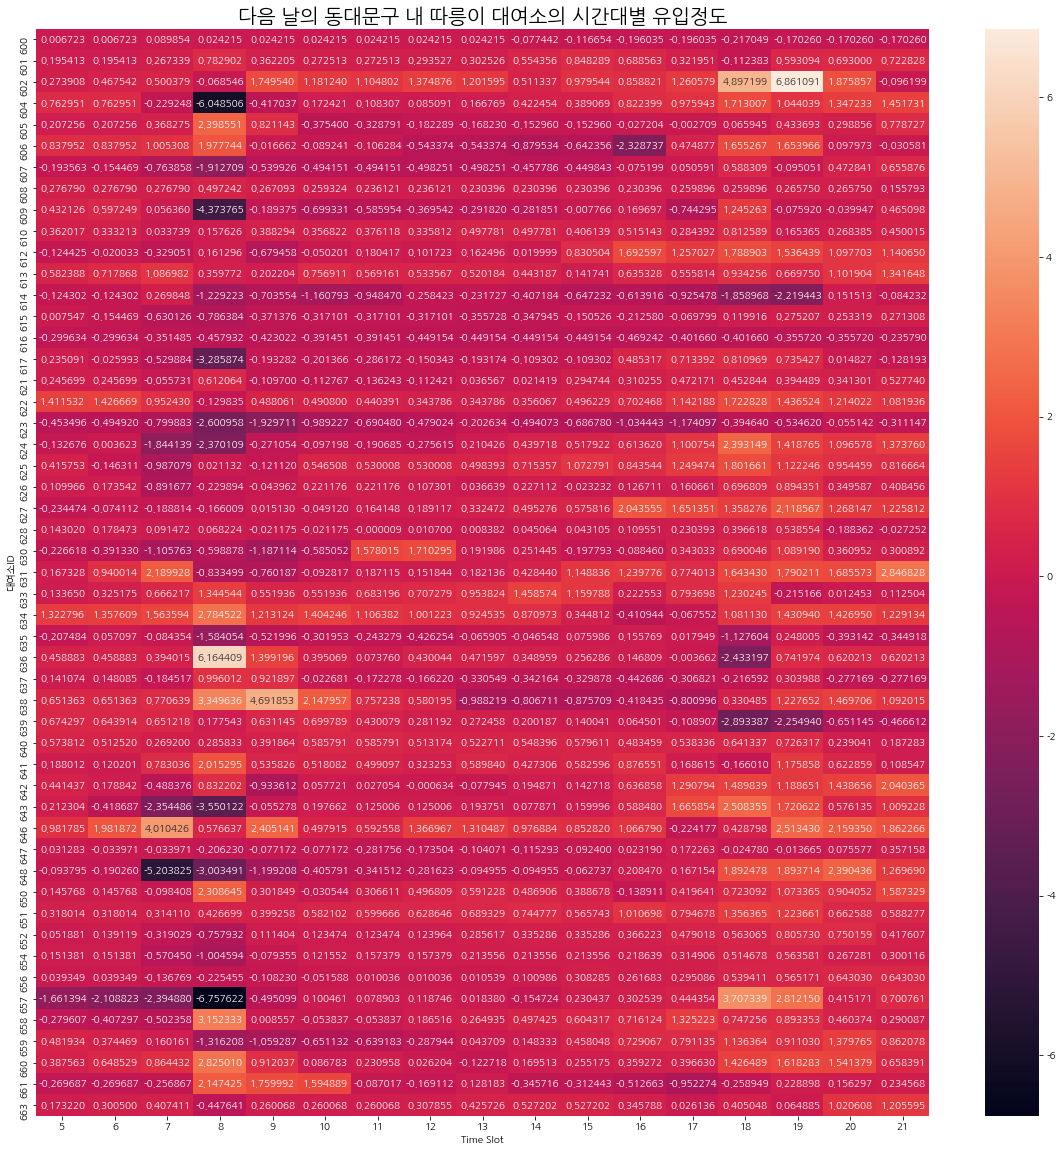

In [51]:
#Bike_Map.fillna(value=np.nan, inplace=True)
plt.figure(figsize=(20,20))
sns.heatmap(Bike_Map, annot=True, fmt=".6f")
plt.title('다음 날의 동대문구 내 따릉이 대여소의 시간대별 유입정도', fontsize=20)
plt.show()

## 대여소간 소요시간(sec 단위) 불러오기

In [52]:
import pickle
with open('./time/Bike_Stop_Time.pickle', 'rb') as fr:
    Bike_Stop_Time = pickle.load(fr)

In [53]:
Bike_Stop_Time

{'600': {'600': 0,
  '601': 925,
  '602': 757,
  '604': 1086,
  '605': 1053,
  '606': 485,
  '607': 702,
  '608': 781,
  '609': 886,
  '610': 1168,
  '612': 1178,
  '613': 1462,
  '614': 1013,
  '615': 981,
  '616': 730,
  '617': 889,
  '621': 856,
  '622': 731,
  '623': 766,
  '624': 903,
  '625': 1020,
  '626': 830,
  '627': 668,
  '628': 542,
  '630': 1058,
  '631': 1118,
  '633': 592,
  '634': 414,
  '635': 270,
  '636': 551,
  '637': 533,
  '638': 908,
  '639': 267,
  '640': 453,
  '641': 880,
  '642': 994,
  '643': 701,
  '646': 965,
  '647': 799,
  '648': 1298,
  '650': 114,
  '651': 347,
  '652': 708,
  '654': 917,
  '656': 467,
  '657': 878,
  '658': 728,
  '659': 765,
  '660': 1119,
  '661': 448,
  '663': 253},
 '601': {'600': 1690,
  '601': 0,
  '602': 1401,
  '604': 852,
  '605': 243,
  '606': 1932,
  '607': 1940,
  '608': 721,
  '609': 755,
  '610': 808,
  '612': 413,
  '613': 680,
  '614': 187,
  '615': 99,
  '616': 670,
  '617': 856,
  '621': 765,
  '622': 1359,
  '623':

## 대여소별 경도 위도 불러오기

In [54]:
with open('./time/Bike_Stop_POS.pickle', 'rb') as fr:
    Bike_Stop_POS = pickle.load(fr)

In [55]:
Bike_Stop_POS

{'600': {'x': '127.06868', 'y': '37.589912'},
 '601': {'x': '127.037361', 'y': '37.575947'},
 '602': {'x': '127.071388', 'y': '37.572174'},
 '604': {'x': '127.055962', 'y': '37.569656'},
 '605': {'x': '127.026497', 'y': '37.5742'},
 '606': {'x': '127.07029', 'y': '37.584625'},
 '607': {'x': '127.067863', 'y': '37.602711'},
 '608': {'x': '127.055344', 'y': '37.58131'},
 '609': {'x': '127.037361', 'y': '37.587791'},
 '610': {'x': '127.052162', 'y': '37.573086'},
 '612': {'x': '127.030815', 'y': '37.573666'},
 '613': {'x': '127.023468', 'y': '37.575272'},
 '614': {'x': '127.031013', 'y': '37.577686'},
 '615': {'x': '127.03511', 'y': '37.576382'},
 '616': {'x': '127.054367', 'y': '37.582561'},
 '617': {'x': '127.057693', 'y': '37.574203'},
 '621': {'x': '127.053391', 'y': '37.574718'},
 '622': {'x': '127.057831', 'y': '37.577793'},
 '623': {'x': '127.053856', 'y': '37.583698'},
 '624': {'x': '127.045891', 'y': '37.574188'},
 '625': {'x': '127.057175', 'y': '37.568192'},
 '626': {'x': '127.